In [1]:
import json

import nltk
from nltk.corpus import wordnet

import re
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, create_optimizer
from transformers import T5ForConditionalGeneration, T5Tokenizer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/opt/miniconda3/envs/clean_tf_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# Load the T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base')

def paraphrase(sentence, num_return_sequences=5, num_beams=5):
    # Preprocess the input sentence
    text = "paraphrase: " + sentence + " </s>"
    encoding = tokenizer.encode_plus(text, max_length=512, padding='max_length', return_tensors="pt")
    
    # Generate paraphrases
    input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]
    outputs = model.generate(
        input_ids=input_ids, attention_mask=attention_mask,
        max_length=512,
        num_beams=num_beams,
        num_return_sequences=num_return_sequences,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )
    
    # Decode and return the paraphrased sentences
    paraphrases = [tokenizer.decode(output, skip_special_tokens=True, 
                                    clean_up_tokenization_spaces=True) 
                                    for output in outputs]
    return paraphrases

# Example
original_sentence = "The restaurant's aesthetic, too, has grown with time, now an Instagram-worthy ambiance from every corner."
paraphrased_sentences = paraphrase(original_sentence, num_return_sequences=5)

for i, sentence in enumerate(paraphrased_sentences):
    print(f"Paraphrase {i+1}: {sentence}")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/miniconda3/envs/clean_tf_env/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Paraphrase 1: True
Paraphrase 2: positive
Paraphrase 3: negative
Paraphrase 4: Falsch
Paraphrase 5: Falses


In [3]:
# Step 1: Load the JSON file
with open('/Users/pablonieuwenhuys/EatzAI/latest.json', 'r') as f:
    data = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/pablonieuwenhuys/EatzAI/latest.json'

In [ ]:

augmented_sentences = []
augmented_labels = []

for item in data:
    text = item.get('data', {}).get('text', "")
    annotations = item.get('annotations', [])
    if annotations and 'result' in annotations[0]:
        results = annotations[0]['result']
        if results and 'value' in results[0] and 'choices' in results[0]['value']:
            sentence_labels = results[0]['value']['choices']
        else:
            sentence_labels = []
    else:
        sentence_labels = []

    # 'Ambiance' and 'Service' are underrepresented in the dataset so new paraphrased- 
    # -sentences will be created
    if 'ambiance' in sentence_labels or 'service' in sentence_labels:
        # Generate paraphrases
        paraphrased_sentences = paraphrase(text, num_return_sequences=5)
        for paraphrased_sentence in paraphrased_sentences:
            augmented_sentences.append(paraphrased_sentence)
            augmented_labels.append(sentence_labels)

# Combine original and augmented data
for item in data:
    text = item.get('data', {}).get('text', "")
    annotations = item.get('annotations', [])
    if annotations and 'result' in annotations[0]:
        results = annotations[0]['result']
        if results and 'value' in results[0] and 'choices' in results[0]['value']:
            sentence_labels = results[0]['value']['choices']
        else:
            sentence_labels = []
    else:
        sentence_labels = []

    augmented_sentences.append(text)
    augmented_labels.append(sentence_labels)

# Check the number of sentences generated
num_sentences = len(augmented_sentences)
print(f"Total number of sentences generated (including original and augmented): {num_sentences}")


Total number of sentences generated (including original and augmented): 2356


In [ ]:
import json

# Combine sentences and labels into a list of dictionaries
augmented_data = [{'sentence': sentence, 'labels': label} for sentence, label in zip(augmented_sentences, augmented_labels)]

# Define the output JSON file path
output_json_file = 'augmented_sentences.json'

# Write to the JSON file
with open(output_json_file, 'w') as file:
    json.dump(augmented_data, file, indent=4)

print(f"Augmented sentences and labels saved to {output_json_file}")


Augmented sentences and labels saved to augmented_sentences.json


In [ ]:
# Step 3: Preprocess Text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

nltk.download('punkt')
sentences = [preprocess_text(sentence) for sentence in augmented_sentences]
labels = augmented_labels

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pablonieuwenhuys/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Step 4: Encode Labels
mlb = MultiLabelBinarizer()
labels_encoded = mlb.fit_transform(labels)

In [ ]:
for row in labels_encoded:
    print(row)

[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 1]
[1 0 0 1]
[1 0 0 1]
[1 0 0 1]
[1 0 0 1]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[0 1 0 1]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[1 0 0 0]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[1 1 0 0]
[1 1 0 0]
[1 1 0 0]
[1 1 0 0]
[1 1 0 0]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[0 0 0 1]
[1 0 0 1]
[1 0 0 1]
[1 0 0 1]
[1 0 0 1]
[1 0 0 1]


In [ ]:
# Step 5: Tokenize Sentences using DistilBERT Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encodings = tokenizer(sentences, truncation=True, padding=True)

input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']

In [ ]:
# Step 6: Split the Data into Training and Validation Sets
train_input_ids, val_input_ids, train_attention_masks, val_attention_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_masks, labels_encoded, test_size=0.2, random_state=0
)

# Convert input_ids and attention_masks to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_input_ids,
        'attention_mask': train_attention_masks
    },
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_input_ids,
        'attention_mask': val_attention_masks
    },
    val_labels
))


2024-08-22 11:05:56.957036: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-22 11:05:56.957209: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-22 11:05:56.957228: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-22 11:05:56.957799: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-22 11:05:56.958413: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
print(labels)

[['service'], ['service'], ['service'], ['service'], ['service'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['service', 'ambiance'], ['service', 'ambiance'], ['service', 'ambiance'], ['service', 'ambiance'], ['service', 'ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['service'], ['service'], ['service'], ['service'], ['service'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['ambiance'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['food', 'service'], ['food', 'servic

In [ ]:
# Convert the list of lists to a tuple of tuples
lst_of_tuples = [tuple(sublist) for sublist in labels_encoded]

# Use a dictionary to count the occurrences of each tuple
counter = {}
for sublist in lst_of_tuples:
    if sublist in counter:
        counter[sublist] += 1
    else:
        counter[sublist] = 1

# Print the results
for sublist, count in counter.items():
    print(f'The sublist {list(sublist)} appears {count} times.')

The sublist [0, 0, 0, 1] appears 948 times.
The sublist [1, 0, 0, 0] appears 354 times.
The sublist [1, 0, 0, 1] appears 84 times.
The sublist [0, 1, 0, 1] appears 210 times.
The sublist [1, 1, 0, 0] appears 114 times.
The sublist [1, 1, 0, 1] appears 60 times.
The sublist [0, 0, 1, 0] appears 213 times.
The sublist [0, 1, 0, 0] appears 368 times.
The sublist [0, 0, 0, 0] appears 5 times.


In [ ]:
print(train_labels)

[[0 0 0 1]
 [0 0 0 1]
 [1 1 0 0]
 ...
 [1 1 0 0]
 [0 0 0 1]
 [1 1 0 1]]


In [ ]:
train_dataset = train_dataset.shuffle(buffer_size=1000)

In [ ]:
#Define and Compile the Model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', 
                                                              num_labels=labels_encoded.shape[1])

num_train_steps = len(train_dataset) * 5  # Assuming 5 epochs
# Define the learning rate schedule with warmup steps
lr_schedule = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=3e-5,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=1.0,
    alpha=0.0,
    name=None
)

# Define the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
#Train the Model
history = model.fit(
    train_dataset.batch(32),
    epochs=10,
    validation_data=val_dataset.batch(16),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=3, 
                                                restore_best_weights=True)]
)


Epoch 1/10
59/59 [==============================] - 83s 1s/step - loss: 0.5229 - accuracy: 0.4995 - val_loss: 0.4441 - val_accuracy: 0.5869
Epoch 2/10
59/59 [==============================] - 75s 1s/step - loss: 0.3841 - accuracy: 0.6725 - val_loss: 0.3831 - val_accuracy: 0.6801
Epoch 3/10
59/59 [==============================] - 75s 1s/step - loss: 0.3029 - accuracy: 0.7415 - val_loss: 0.3156 - val_accuracy: 0.6928
Epoch 4/10
59/59 [==============================] - 79s 1s/step - loss: 0.2525 - accuracy: 0.7633 - val_loss: 0.2955 - val_accuracy: 0.6780
Epoch 5/10
59/59 [==============================] - 78s 1s/step - loss: 0.2200 - accuracy: 0.7728 - val_loss: 0.2939 - val_accuracy: 0.6992
Epoch 6/10
59/59 [==============================] - 77s 1s/step - loss: 0.2046 - accuracy: 0.7845 - val_loss: 0.2984 - val_accuracy: 0.6801
Epoch 7/10
59/59 [==============================] - 80s 1s/step - loss: 0.1953 - accuracy: 0.7744 - val_loss: 0.2917 - val_accuracy: 0.6864
Epoch 8/10
59/59 [==

In [ ]:
# Save the model to a directory
model.save('/Users/pablonieuwenhuys/EatzAI/comment_model_22082024')
print("Model saved to 'my_model_directory'")

INFO:tensorflow:Assets written to: comment_model_22082024/assets


INFO:tensorflow:Assets written to: comment_model_22082024/assets


Model saved to 'my_model_directory'


In [ ]:
# Step 9: Evaluate the Model
val_predictions = model.predict(val_dataset.batch(16))
val_probs = tf.nn.sigmoid(val_predictions.logits)
val_preds = (val_probs > 0.5).numpy()  # Adjust threshold as needed

# Print evaluation metrics (e.g., precision, recall, F1-score)
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=mlb.classes_, zero_division=0))

precision = precision_score(val_labels, val_preds, average='micro', zero_division=0)
recall = recall_score(val_labels, val_preds, average='micro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='micro', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

30/30 [==============================] - 3s 116ms/step
Classification Report:
              precision    recall  f1-score   support

    ambiance       0.95      0.39      0.56       132
        food       0.95      0.66      0.78       161
        none       0.79      0.79      0.79        38
     service       0.79      0.98      0.87       250

   micro avg       0.84      0.74      0.79       581
   macro avg       0.87      0.70      0.75       581
weighted avg       0.87      0.74      0.77       581
 samples avg       0.82      0.77      0.79       581

Precision: 0.8405
Recall: 0.7435
F1-Score: 0.7890


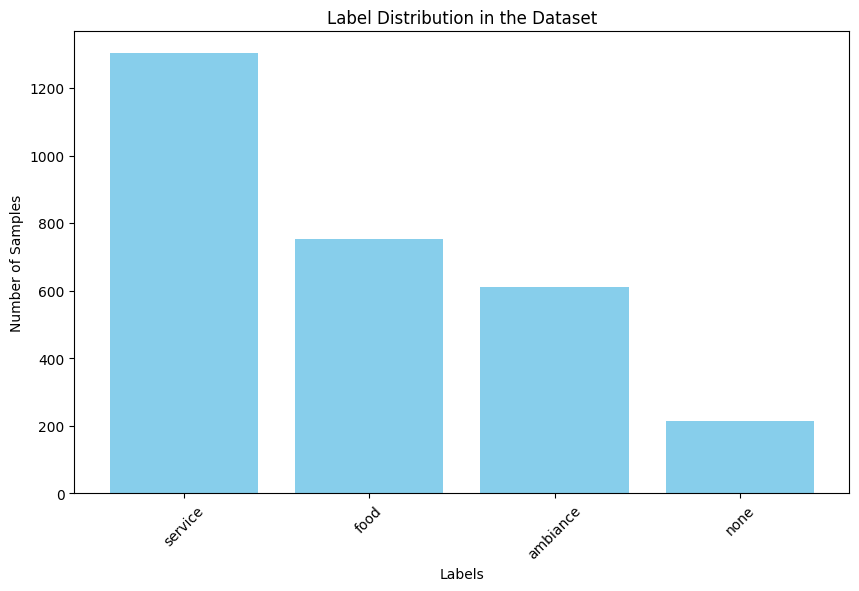

3    1302
1     752
0     612
2     213
Name: Count, dtype: int64 3     service
1        food
0    ambiance
2        none
Name: Label, dtype: object


In [ ]:

# Sum over the samples (axis=0) to count the number of occurrences for each label
label_counts = np.sum(labels_encoded, axis=0)

# Convert to a pandas DataFrame for easier plotting
label_counts_df = pd.DataFrame({
    'Label': mlb.classes_,
    'Count': label_counts
})

# Sort the DataFrame by count for better visualization
label_counts_df = label_counts_df.sort_values('Count', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(label_counts_df['Label'], label_counts_df['Count'], color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Label Distribution in the Dataset')
plt.xticks(rotation=45)
plt.show()
print(label_counts_df['Count'], label_counts_df['Label'])


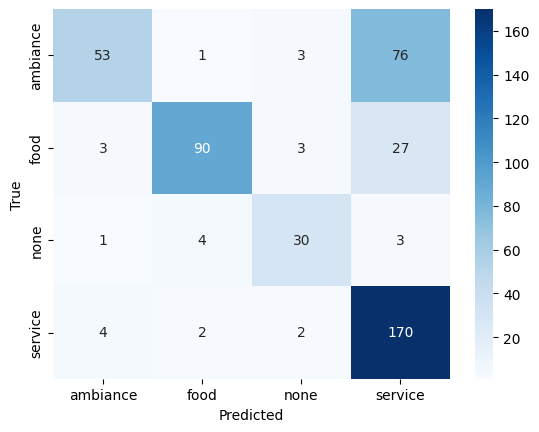

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#Matrix to visualize the labels and to what extent they get predicted correctly
cm = confusion_matrix(np.argmax(val_labels, axis=1), np.argmax(val_preds, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
